In [1]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
from scipy.interpolate import griddata
import pandas as pd
import geopandas as gpd
import contextily as ctx

purple_df = pd.read_csv('/Users/jenniferbadger/Documents/GitHub/229project/final_frame.csv', index_col=None,encoding='UTF-8', delimiter=',')

#purple_df.drop(['Unnamed: 0'])
purple_df['PM2.5 CF1 Mean'].mean() #94.5
purple_df['PM2.5 CF1 Mean'].max() #4475! 
purple_df['PM2.5 CF1 Mean'].min() #0.064
purple_df['PM2.5 CF1 Mean'].median() #15.9

#Trimming data for outliers or potentially uncalibrated sensors
purple_trim = purple_df[purple_df['PM2.5 CF1 Mean']< 30]
purple_trim = purple_trim[purple_df['PM2.5 CF1 Mean']> 5]
purple_trim.head()
#purple_df.head()

<ipython-input-1-788214bd0840>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  purple_trim = purple_trim[purple_df['PM2.5 CF1 Mean']> 5]


,Unnamed: 0,created_at,filename,lat,long,PM2.5 ATM Mean,PM2.5 CF1 Mean
0,0,2019-03-16 00:00:00 UTC,CCA 61st and King (outside) (33.98329 -118.183...,33.983290,-118.183926,16.995496,18.172958
1,1,2019-03-16 00:00:00 UTC,CCA 52nd Dr and Heliotrope (outside) (33.98995...,33.989950,-118.178093,16.328882,17.597437
2,2,2019-03-26 00:00:00 UTC,Adams Square (inside) (inside) (34.133594 -118...,34.133594,-118.241213,12.812237,14.105855
3,3,2019-03-27 00:00:00 UTC,CSUN Live Oak (outside) (34.238179 -118.528333...,34.238179,-118.528333,13.484826,13.641279
4,4,2019-01-09 00:00:00 UTC,6th St (inside) (34.020076 -118.49534) Primary...,34.020076,-118.495340,6.793395,7.069488


In [2]:
len(purple_df)

110

In [3]:
len(purple_trim)

97

[(-118.7, -117.9), (33.9, 34.25)]

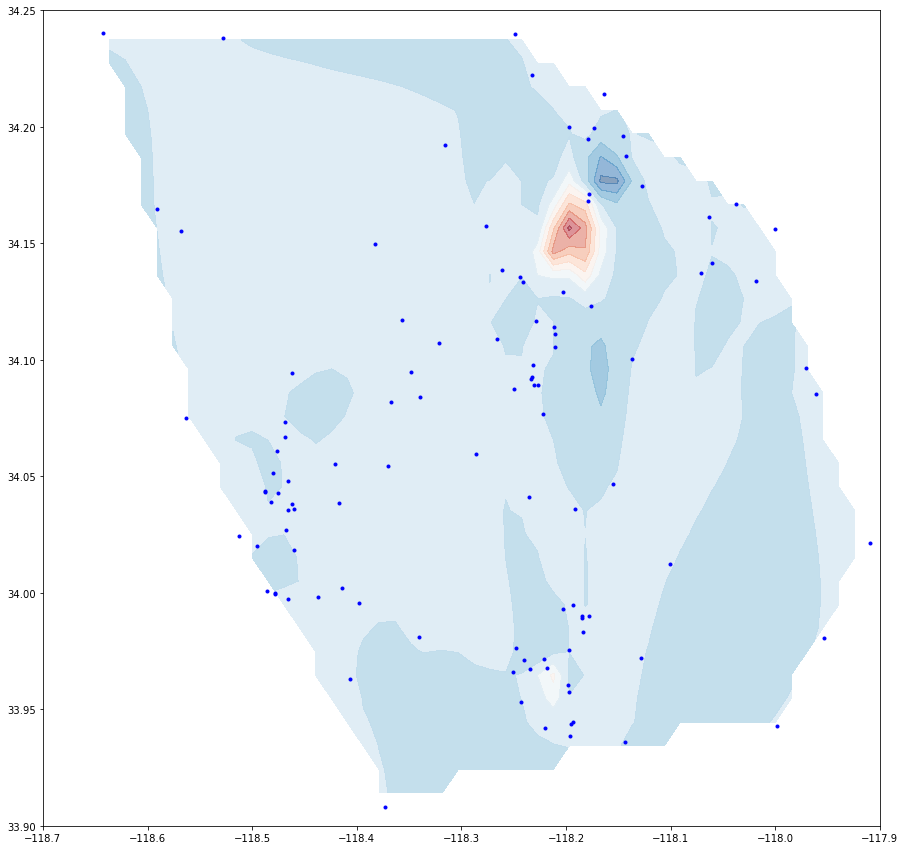

In [29]:
#CONTOUR SURFACE: FIRST ITERATION 

#https://matplotlib.org/stable/gallery/images_contours_and_fields/irregulardatagrid.html

xpts = purple_df['long']
ypts = purple_df['lat']
zpts = purple_df['PM2.5 CF1 Mean']

min(xpts) #-118.642964
max(xpts) #-117.90991

min(ypts) #33.907907
max(ypts) #34.240106

#creating the plot
fig, ax = plt.subplots(figsize=(15,15))

#linspace returns evenly spaced numbers over a specified interval
#https://numpy.org/devdocs/reference/generated/numpy.linspace.html
xi = np.linspace(start = -119.0, stop = -117.5, num = 100)
yi = np.linspace(33.5, 34.5, 100)


#xi2 = np.linspace(purple_df['long'].min(), purple_df['long'].max())
#yi2 = np.linspace(purple_df['lat'].min(), purple_df['lat'])

X, Y = np.meshgrid(xi,yi)

#interpolation
#griddata interpolates a surface at the points specified by (xi,yi) to produce zi
#scipy.interpolate.griddata(points, values, xi, method='linear', fill_value=nan, rescale=False)
zi = griddata((xpts, ypts), zpts, (X,Y), method='cubic')

#draws contour lines
ax.contour(zi, levels=10, linewidths=0.15, colors='k')

#fills contours, cmap = colormap, alpha = transparency
contour = ax.contourf(xi, yi, zi, levels=10, cmap = "RdBu_r",  alpha = 0.5)

#plots lat/long using bo= blue circle markers
ax.plot(xpts, ypts, 'bo', markersize = 3)
ax.set(xlim=(-118.7, -117.9), ylim=(33.9, 34.25))

In [8]:
#Defining x and y pts in terms of projection 4326
purple_trim_gdf = gpd.GeoDataFrame(
    purple_trim, geometry = gpd.points_from_xy(purple_trim.long, purple_trim.lat, crs='EPSG:4326'))
purple_trim_gdf.head()

,Unnamed: 0,created_at,filename,lat,long,PM2.5 ATM Mean,PM2.5 CF1 Mean,geometry
0,0,2019-03-16 00:00:00 UTC,CCA 61st and King (outside) (33.98329 -118.183...,33.983290,-118.183926,16.995496,18.172958,POINT (-118.18393 33.98329)
1,1,2019-03-16 00:00:00 UTC,CCA 52nd Dr and Heliotrope (outside) (33.98995...,33.989950,-118.178093,16.328882,17.597437,POINT (-118.17809 33.98995)
2,2,2019-03-26 00:00:00 UTC,Adams Square (inside) (inside) (34.133594 -118...,34.133594,-118.241213,12.812237,14.105855,POINT (-118.24121 34.13359)
3,3,2019-03-27 00:00:00 UTC,CSUN Live Oak (outside) (34.238179 -118.528333...,34.238179,-118.528333,13.484826,13.641279,POINT (-118.52833 34.23818)
4,4,2019-01-09 00:00:00 UTC,6th St (inside) (34.020076 -118.49534) Primary...,34.020076,-118.495340,6.793395,7.069488,POINT (-118.49534 34.02008)


In [21]:
#converting gdf with projected coordinates back into df
purple_trim_proj= purple_trim_gdf

#converting geometry column into individual lat/long
purple_trim_proj['lat proj'] = purple_trim_gdf.geometry.apply(lambda x: x.y)

purple_trim_proj['long proj'] = purple_trim_gdf.geometry.apply(lambda x: x.x)

#dropping column
purple_trim_proj = purple_trim_proj.drop(['latproj'], axis = 1)

purple_trim_proj.head()

,Unnamed: 0,created_at,filename,lat,long,PM2.5 ATM Mean,PM2.5 CF1 Mean,geometry,lat proj,long proj
0,0,2019-03-16 00:00:00 UTC,CCA 61st and King (outside) (33.98329 -118.183...,33.983290,-118.183926,16.995496,18.172958,POINT (-118.18393 33.98329),33.983290,-118.183926
1,1,2019-03-16 00:00:00 UTC,CCA 52nd Dr and Heliotrope (outside) (33.98995...,33.989950,-118.178093,16.328882,17.597437,POINT (-118.17809 33.98995),33.989950,-118.178093
2,2,2019-03-26 00:00:00 UTC,Adams Square (inside) (inside) (34.133594 -118...,34.133594,-118.241213,12.812237,14.105855,POINT (-118.24121 34.13359),34.133594,-118.241213
3,3,2019-03-27 00:00:00 UTC,CSUN Live Oak (outside) (34.238179 -118.528333...,34.238179,-118.528333,13.484826,13.641279,POINT (-118.52833 34.23818),34.238179,-118.528333
4,4,2019-01-09 00:00:00 UTC,6th St (inside) (34.020076 -118.49534) Primary...,34.020076,-118.495340,6.793395,7.069488,POINT (-118.49534 34.02008),34.020076,-118.495340


[(-118.7, -117.9), (33.9, 34.25)]

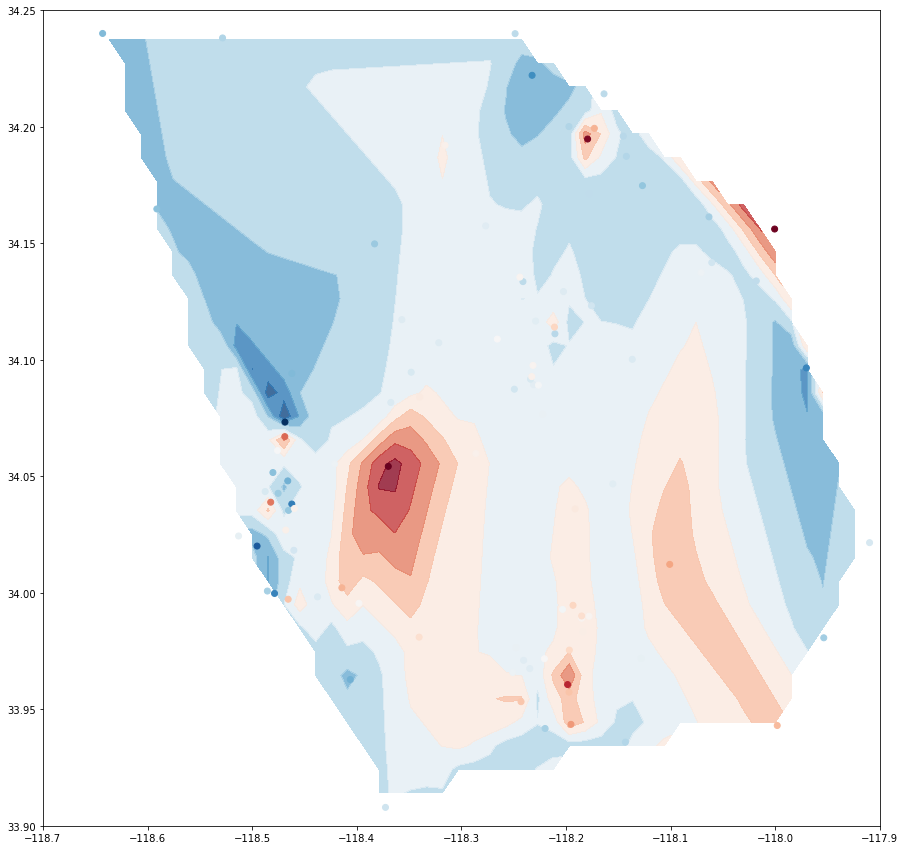

In [30]:
#CONTOUR SURFACE: FINAL ITERATION 

xpts = purple_trim_proj['long proj']
ypts = purple_trim_proj['lat proj']
zpts = purple_trim_proj['PM2.5 CF1 Mean']

min(xpts) #-118.642964
max(xpts) #-117.90991

min(ypts) #33.907907
max(ypts) #34.240106

#creating the plot
fig, ax = plt.subplots(figsize=(15,15))

#linspace returns evenly spaced numbers over a specified interval
#https://numpy.org/devdocs/reference/generated/numpy.linspace.html
xi = np.linspace(start = -119.0, stop = -117.5, num = 100)
yi = np.linspace(33.5, 34.5, 100)

# meshgrid creates a rectangular grid out of an array of x values and an array of y values.
X, Y = np.meshgrid(xi,yi)

#interpolation
#griddata interpolates a surface at the points specified by (xi,yi) to produce zi
#scipy.interpolate.griddata(points, values, xi, method='linear', fill_value=nan, rescale=False)
zi = griddata((xpts, ypts), zpts, (X,Y), method='linear')
                       
#draws contour lines
ax.contour(zi, levels=10, linewidths= 1.5, colors='k')

#fills contours, cmap = colormap, alpha = transparency
contour = ax.contourf(xi, yi, zi, levels=10, cmap = "RdBu_r",  alpha = 0.8)

#plots sensor locations using bo= blue circle markers
#ax.plot(xpts, ypts, 'bo', markersize = 3)

#plots sensor locations with colormap expressing pm2.5 mean gradients
scatter = ax.scatter(xpts, ypts, c = zpts ,cmap = "RdBu_r")
#setting the axes
ax.set(xlim=(-118.7, -117.9), ylim=(33.9, 34.25))


In [28]:
#saving the fig
#fig.savefig('contour_scatter.png')

#fig.savefig('contour.png')

In [31]:
#checking interpolated value array
len(zi) #1128

100

In [32]:
print(zi) # zi looks like a bunch of nans

np.count_nonzero(np.isnan(zi)) #8872
np.isnan(zi).sum() #returns 8872

np.count_nonzero(~np.isnan(zi)) #1128 values

#zi total = 10000 values
#approximately 10% of the nodes have predicted pm 2.5 values

#has to do with points being outside of convex hull
#https://stackoverflow.com/questions/37643934/nan-values-are-from-griddata

zi_df = pd.DataFrame(zi)
zi_df.head()

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
#checking linspace array
len(xi) #100
xi #returns a reasonable looking array


array([-119.        , -118.98484848, -118.96969697, -118.95454545,
       -118.93939394, -118.92424242, -118.90909091, -118.89393939,
       -118.87878788, -118.86363636, -118.84848485, -118.83333333,
       -118.81818182, -118.8030303 , -118.78787879, -118.77272727,
       -118.75757576, -118.74242424, -118.72727273, -118.71212121,
       -118.6969697 , -118.68181818, -118.66666667, -118.65151515,
       -118.63636364, -118.62121212, -118.60606061, -118.59090909,
       -118.57575758, -118.56060606, -118.54545455, -118.53030303,
       -118.51515152, -118.5       , -118.48484848, -118.46969697,
       -118.45454545, -118.43939394, -118.42424242, -118.40909091,
       -118.39393939, -118.37878788, -118.36363636, -118.34848485,
       -118.33333333, -118.31818182, -118.3030303 , -118.28787879,
       -118.27272727, -118.25757576, -118.24242424, -118.22727273,
       -118.21212121, -118.1969697 , -118.18181818, -118.16666667,
       -118.15151515, -118.13636364, -118.12121212, -118.10606

In [33]:
#checking linspace array
len(yi) #100
yi #returns a reasonable looking array

array([33.5       , 33.51010101, 33.52020202, 33.53030303, 33.54040404,
       33.55050505, 33.56060606, 33.57070707, 33.58080808, 33.59090909,
       33.6010101 , 33.61111111, 33.62121212, 33.63131313, 33.64141414,
       33.65151515, 33.66161616, 33.67171717, 33.68181818, 33.69191919,
       33.7020202 , 33.71212121, 33.72222222, 33.73232323, 33.74242424,
       33.75252525, 33.76262626, 33.77272727, 33.78282828, 33.79292929,
       33.8030303 , 33.81313131, 33.82323232, 33.83333333, 33.84343434,
       33.85353535, 33.86363636, 33.87373737, 33.88383838, 33.89393939,
       33.9040404 , 33.91414141, 33.92424242, 33.93434343, 33.94444444,
       33.95454545, 33.96464646, 33.97474747, 33.98484848, 33.99494949,
       34.00505051, 34.01515152, 34.02525253, 34.03535354, 34.04545455,
       34.05555556, 34.06565657, 34.07575758, 34.08585859, 34.0959596 ,
       34.10606061, 34.11616162, 34.12626263, 34.13636364, 34.14646465,
       34.15656566, 34.16666667, 34.17676768, 34.18686869, 34.19